In [15]:
import os
print(os.getcwd())


c:\Users\RitaML\Documents\GitHub\EDSB25_10


In [16]:
import pandas as pd
import numpy as np
import os 
from sklearn.preprocessing import StandardScaler

DATA_PATH = 'data/processed/'

X_train = pd.read_csv(os.path.join(DATA_PATH, 'X_train.csv'))
X_val = pd.read_csv(os.path.join(DATA_PATH, 'X_val.csv'))
X_test = pd.read_csv(os.path.join(DATA_PATH, 'X_test.csv'))

y_train = pd.read_csv(os.path.join(DATA_PATH, 'y_train.csv')).squeeze()
y_val = pd.read_csv(os.path.join(DATA_PATH, 'y_val.csv')).squeeze()
y_test = pd.read_csv(os.path.join(DATA_PATH, 'y_test.csv')).squeeze()


In [17]:
# ======================
# 1. Custom categorical encoding
# ======================

# Department: do NOT drop any category
for X in [X_train, X_val, X_test]:
    dummies = pd.get_dummies(X['Department'], prefix='Department', drop_first=False)
    X.drop('Department', axis=1, inplace=True)
    X[dummies.columns] = dummies

# EducationField: drop ONLY 'Other'
def encode_educationfield(df):
    edu_dummies = pd.get_dummies(df['EducationField'], prefix='EducationField')
    if 'EducationField_Other' in edu_dummies.columns:
        edu_dummies = edu_dummies.drop('EducationField_Other', axis=1)
    df = df.drop('EducationField', axis=1)
    df[edu_dummies.columns] = edu_dummies
    return df

X_train = encode_educationfield(X_train)
X_val = encode_educationfield(X_val)
X_test = encode_educationfield(X_test)

# JobRole: do NOT drop any category
for X in [X_train, X_val, X_test]:
    dummies = pd.get_dummies(X['JobRole'], prefix='JobRole', drop_first=False)
    X.drop('JobRole', axis=1, inplace=True)
    X[dummies.columns] = dummies

# The remaining categorical variables: drop first
drop_first_vars = ['BusinessTravel', 'Gender', 'MaritalStatus', 'OverTime']
for col in drop_first_vars:
    for X in [X_train, X_val, X_test]:
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
        X.drop(col, axis=1, inplace=True)
        X[dummies.columns] = dummies

# Ensure all sets have the same columns (fill missing columns with zero)
all_columns = sorted(set(X_train.columns) | set(X_val.columns) | set(X_test.columns))
for X in [X_train, X_val, X_test]:
    missing_cols = set(all_columns) - set(X.columns)
    for col in missing_cols:
        X[col] = 0
    X = X[all_columns]
    X.reset_index(drop=True, inplace=True)
    
# Update references in case columns were reordered above
X_train = X_train[all_columns].reset_index(drop=True)
X_val = X_val[all_columns].reset_index(drop=True)
X_test = X_test[all_columns].reset_index(drop=True)

# ======================
# 2. Scaling numeric & ordinal features
# ======================

ordinal_cols = [
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance'
]
numeric_cols = [
    col for col in X_train.columns
    if (X_train[col].dtype in ['int64', 'float64']) and (col in ordinal_cols or not col.startswith(('Department_', 'EducationField_', 'JobRole_', 'BusinessTravel_', 'Gender_', 'MaritalStatus_', 'OverTime_')))
]
scale_cols = numeric_cols + ordinal_cols

scaler = StandardScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_val[scale_cols] = scaler.transform(X_val[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

# Now X_train, X_val, X_test are ready for logistic regression!


## To do

In [18]:
# fetch log transformed features
X_train['TotalWorkingYearsLog'] = np.log(X_train['TotalWorkingYears']+1#, where=HR_1['TotalWorkingYears']>0
                                      )
X_train['YearsAtCompanyLog'] = np.log(X_train['YearsAtCompany']+1#, where=HR_1['YearsAtCompany']>0
                                   )
X_val['TotalWorkingYearsLog'] = np.log(X_val['TotalWorkingYears']+1#, where=HR_1['TotalWorkingYears']>0
                                      )
X_val['YearsAtCompanyLog'] = np.log(X_val['YearsAtCompany']+1#, where=HR_1['YearsAtCompany']>0
                                      )
X_test['TotalWorkingYearsLog'] = np.log(X_test['TotalWorkingYears']+1#, where=HR_1['TotalWorkingYears']>0
                                        )
X_test['YearsAtCompanyLog'] = np.log(X_test['YearsAtCompany']+1#, where=HR_1['YearsAtCompany']>0
                                        )
# create new feature Job_happiness_score
X_train['Job_happiness_score'] = X_train['JobInvolvement'] + X_train['JobSatisfaction'] + X_train['YearsAtCompanyLog'] + X_train['EnvironmentSatisfaction'] + X_train['WorkLifeBalance'] - X_train['OverTime_Yes'] #-> -0.33 correlation
X_val['Job_happiness_score'] = X_val['JobInvolvement'] + X_val['JobSatisfaction'] + X_val['YearsAtCompanyLog'] + X_val['EnvironmentSatisfaction'] + X_val['WorkLifeBalance'] - X_val['OverTime_Yes']
X_test['Job_happiness_score'] = X_test['JobInvolvement'] + X_test['JobSatisfaction'] + X_test['YearsAtCompanyLog'] + X_test['EnvironmentSatisfaction'] + X_test['WorkLifeBalance'] - X_test['OverTime_Yes']
# ======================
# 3. Feature selection
# ======================
# Feature selection
selected_features = [
    'JobSatisfaction', 'JobInvolvement', 'EnvironmentSatisfaction',
    'JobRole_Research Director', 'JobRole_Sales Representative', 'BusinessTravel_Travel_Frequently',
    'WorkLifeBalance', 'Department_Research & Development', 'YearsAtCompanyLog',
    'TotalWorkingYearsLog', 'MaritalStatus_Single', 'OverTime_Yes', 'JobRole_Laboratory Technician',
    'JobRole_Manufacturing Director', 'MaritalStatus_Married', 'JobRole_Manager',
    'NumCompaniesWorked', 'JobRole_Healthcare Representative', 'Job_happiness_score'
]
# append Attrition var to selected features for later use
#selected_all = selected_features.append('Attrition')

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# scale new features
scaler_new = StandardScaler()
X_train[selected_features] = scaler_new.fit_transform(X_train[selected_features])
X_val[selected_features] = scaler_new.transform(X_val[selected_features])
X_test[selected_features] = scaler_new.transform(X_test[selected_features])

X_train
# Now X_train, X_val, X_test are ready for logistic regression with selected features!
# ======================
# 4. Model training and validation
# =====================
# Logistic Regression
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train, y_train)
# y_val_pred = model.predict(X_val)
# # Evaluation
# accuracy = accuracy_score(y_val, y_val_pred)
# precision = precision_score(y_val, y_val_pred)
# recall = recall_score(y_val, y_val_pred)
# f1 = f1_score(y_val, y_val_pred)
# roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
# print(f'Validation Accuracy: {accuracy:.4f}')
# print(f'Validation Precision: {precision:.4f}')
# print(f'Validation Recall: {recall:.4f}')
# print(f'Validation F1 Score: {f1:.4f}')
# print(f'Validation ROC AUC: {roc_auc:.4f}')
# # ======================
# 5. Final evaluation on test set
# ====================
# y_test_pred = model.predict(X_test)
# # Evaluation
# accuracy = accuracy_score(y_test, y_test_pred)
# precision = precision_score(y_test, y_test_pred)
# recall = recall_score(y_test, y_test_pred)
# f1 = f1_score(y_test, y_test_pred)
# roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
# print(f'Test Accuracy: {accuracy:.4f}')
# print(f'Test Precision: {precision:.4f}')
# print(f'Test Recall: {recall:.4f}')
# print(f'Test F1 Score: {f1:.4f}')
# print(f'Test ROC AUC: {roc_auc:.4f}')
# ======================
# 6. Save the model
# ====================
# import joblib
# joblib.dump(model, 'logistic_regression_model.pkl')         

C:\Users\RitaML\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RitaML\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RitaML\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\RitaML\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning

,JobSatisfaction,JobInvolvement,EnvironmentSatisfaction,JobRole_Research Director,JobRole_Sales Representative,BusinessTravel_Travel_Frequently,WorkLifeBalance,Department_Research & Development,YearsAtCompanyLog,TotalWorkingYearsLog,MaritalStatus_Single,OverTime_Yes,JobRole_Laboratory Technician,JobRole_Manufacturing Director,MaritalStatus_Married,JobRole_Manager,NumCompaniesWorked,JobRole_Healthcare Representative,Job_happiness_score
0,1.148131,-2.408232,1.171229,-0.247733,-0.226388,-0.501063,-1.064625,-1.382350,0.761659,0.539066,-0.689142,-0.646534,-0.483287,-0.328695,1.092717,-0.277350,-0.696188,-0.304855,0.296442
1,1.148131,-1.006212,0.252985,-0.247733,-0.226388,-0.501063,0.336866,-1.382350,0.553392,-0.123105,1.451080,-0.646534,-0.483287,-0.328695,-0.915150,-0.277350,-0.696188,-0.304855,0.748189
2,1.148131,-1.006212,0.252985,-0.247733,-0.226388,1.995758,-2.466116,0.723406,-2.485643,0.716462,-0.689142,1.546709,-0.483287,-0.328695,1.092717,-0.277350,0.109108,-0.304855,-2.763225
3,0.248796,-1.006212,1.171229,-0.247733,-0.226388,-0.501063,0.336866,0.723406,0.256218,-1.499887,-0.689142,-0.646534,2.069163,-0.328695,1.092717,-0.277350,-0.696188,-0.304855,0.530913
4,-1.549875,1.797829,-1.583502,-0.247733,-0.226388,-0.501063,0.336866,-1.382350,0.496125,-0.330541,-0.689142,1.546709,-0.483287,-0.328695,-0.915150,-0.277350,-0.696188,-0.304855,-0.175857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.248796,0.395808,-1.583502,-0.247733,-0.226388,1.995758,0.336866,0.723406,0.351859,-0.946911,-0.689142,1.546709,2.069163,-0.328695,1.092717,-0.277350,-0.696188,-0.304855,-0.156315
878,1.148131,0.395808,1.171229,-0.247733,-0.226388,-0.501063,0.336866,0.723406,0.351859,-0.330541,-0.689142,1.546709,-0.483287,-0.328695,1.092717,-0.277350,0.109108,-0.304855,1.022694
879,0.248796,-1.006212,-1.583502,-0.247733,-0.226388,-0.501063,0.336866,0.723406,0.876759,0.867201,-0.689142,-0.646534,-0.483287,3.042337,1.092717,-0.277350,-0.696188,-0.304855,0.108523
880,-1.549875,0.395808,1.171229,-0.247733,-0.226388,-0.501063,0.336866,0.723406,0.967432,1.167490,-0.689142,-0.646534,-0.483287,-0.328695,1.092717,3.605551,-1.098836,-0.304855,0.937530


In [ ]:
#check NaN values
print(X_train.isna().sum()) # não percebo como é que há NaN values aqui com a log transformation?

JobSatisfaction                       0
JobInvolvement                        0
EnvironmentSatisfaction               0
JobRole_Research Director             0
JobRole_Sales Representative          0
BusinessTravel_Travel_Frequently      0
WorkLifeBalance                       0
Department_Research & Development     0
YearsAtCompanyLog                    21
TotalWorkingYearsLog                 95
MaritalStatus_Single                  0
OverTime_Yes                          0
JobRole_Laboratory Technician         0
JobRole_Manufacturing Director        0
MaritalStatus_Married                 0
JobRole_Manager                       0
NumCompaniesWorked                    0
JobRole_Healthcare Representative     0
Job_happiness_score                  21
dtype: int64


In [21]:
#replace NaN values with 0
X_train = X_train.fillna(0)

In [22]:
from sklearn.linear_model import LogisticRegression


# Example: Minimal preprocessing/sklearn pipeline
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)
y_val_proba = model.predict_proba(X_val)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))

print("Validation Precision:", precision_score(y_val, y_pred_val))
print("Test Precision:", precision_score(y_test, y_pred_test))
print("Validation Recall:", recall_score(y_val, y_pred_val))
print("Test Recall:", recall_score(y_test, y_pred_test))
print("Validation F1 Score:", f1_score(y_val, y_pred_val))
print("Test F1 Score:", f1_score(y_test, y_pred_test))

print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

print("\nClassification report for validation set:\n", classification_report(y_val, y_pred_val))
print("\nClassification report for test set:\n", classification_report(y_test, y_pred_test))


Validation Accuracy: 0.8945578231292517
Test Accuracy: 0.8707482993197279
Validation ROC AUC: 0.827633732448962
Test ROC AUC: 0.7893014040830388
Validation Precision: 0.75
Test Precision: 0.68
Validation Recall: 0.5106382978723404
Test Recall: 0.3617021276595745
Validation F1 Score: 0.6075949367088608
Test F1 Score: 0.4722222222222222

Validation Confusion Matrix:
 [[239   8]
 [ 23  24]]

Test Confusion Matrix:
 [[239   8]
 [ 30  17]]

Classification report for validation set:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       247
           1       0.75      0.51      0.61        47

    accuracy                           0.89       294
   macro avg       0.83      0.74      0.77       294
weighted avg       0.89      0.89      0.89       294


Classification report for test set:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       247
           1       0.68      0.36      0.47

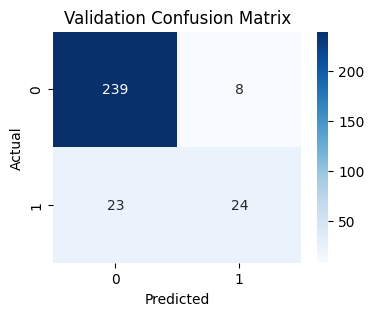

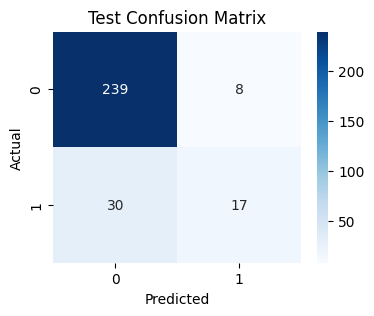

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# You can use scikit-learn's built-in ConfusionMatrixDisplay, or use seaborn heatmap:

def plot_conf_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_val, y_pred_val, 'Validation Confusion Matrix')
plot_conf_matrix(y_test, y_pred_test, 'Test Confusion Matrix')


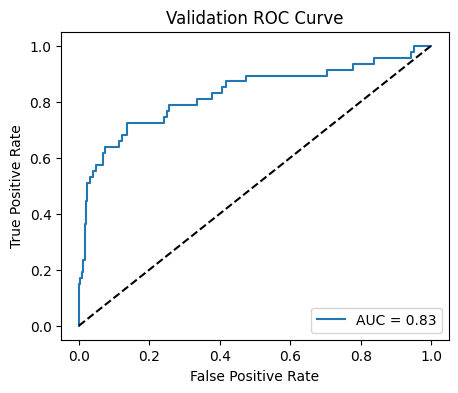

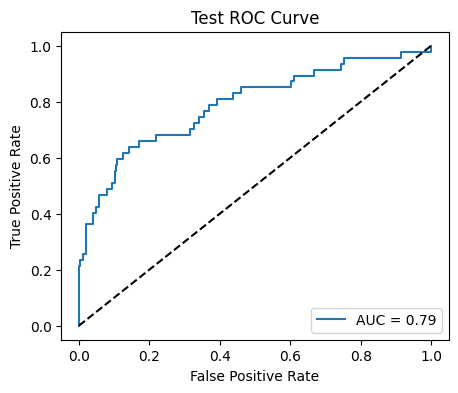

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(y_val, y_val_proba, 'Validation ROC Curve')
plot_roc(y_test, y_test_proba, 'Test ROC Curve')
